# Numerical solution of nonlinear equations

Given a function $f:I \subseteq \mathbb{R} \to \mathbb{R}$, we are dealing with the problem of finding $\alpha\in\mathbb{R}$ such that $f(\alpha)=0$. 
Methods to solve this kind pf problems are generally iterative, generating a sequence of numbers $x^{(k)}$ that will hopefully converge to $\alpha$. 


In this exercise session we will focus on the following methods presented during the course:

1. Bisection method
2. Newton method
3. Chord method
4. Secant method
5. Fixed point iterations

In particular we will implement these methods and compare them by solving a given nonlinear equation.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We start from the implementation of a function (Legendre polynomial of order 5). The equation $f(\alpha)=0$ will then have 5 solutions.

In [2]:
# you can use sympy to differentiate the function ..
import sympy as sym
t = sym.symbols('t')
f_sym = t/8. * (63.*t**4 - 70.*t**2. +15.) # Legendre polynomial of order 5
f_prime_sym = sym.diff(f_sym, t)

f = sym.lambdify(t, f_sym, 'numpy')
f_prime = sym.lambdify(t, f_prime_sym, 'numpy')

# ..or you can differentiate by hand
def f(t):
    return (t/8.0) * (63*t**4 - 70*t**2 + 15)

def f_prime(t):
    return (1/8.0) * (315*t**4 - 210*t**2 + 15)

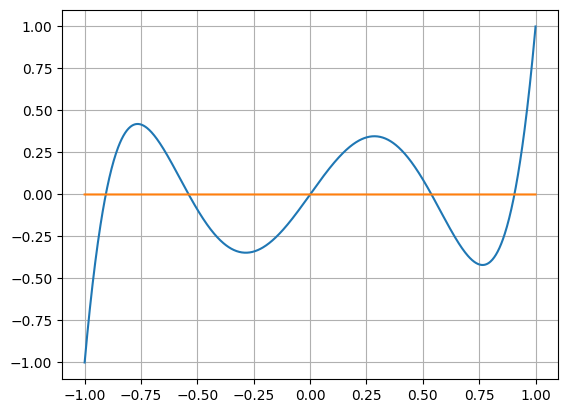

In [3]:
n = 1025
x = np.linspace(-1, 1, n)
c = np.zeros_like(x)
plt.plot(x, f(x))
plt.plot(x, c)
plt.grid()

To compare the algorithms, we start from the same initial point and with the same tollerances and stopping criteria. 

In [4]:
# Initial data for the various algorithms

# interval in which we seek the solution
a = 0.75
b = 1.

# initial points
x0 = (a+b)/2.0
x00 = b

In [5]:
# stopping criteria
eps = 1e-10
n_max = 1000

## Bisection method

This method is used to compute the roots of a _continous_ function $f:[a,b]\to\mathbb{R}$. 
Theorem of existence of zeroes for continuos functions states that if $f(a)f(b)<0$, then $f$ has at least one zero in $(a,b)$.
By iteratively bisecting the interval, we can generate a sequence of intervals of exponentially decreasing length $(a^{(k)},b^{(k)})$ such that, $\forall k$, $\alpha \in (a^{(k)},b^{(k)})$.

In [6]:
def bisect(f, a, b, eps, n_max):
    """
    Bisection method for finding a root of a continuous function on [a, b].

    Parameters
    ----------
    f : Callable[[float], float]
        The function for which we want to find a root.
    a : float
        Left endpoint of the interval.
    b : float
        Right endpoint of the interval.
    eps : float
        Stopping tolerance. The iteration stops when the error is <= eps.
    n_max : int
        Maximum number of iterations.

    Returns
    -------
    root : float
        Approximate root of f in [a, b].
    n_iter : int
        Number of iterations performed.
    errors : List[float]
        History of error estimates at each iteration.

    Notes
    -----
    - The method assumes that f(a) and f(b) have opposite signs
      (i.e., the Intermediate Value Theorem guarantees a root).
    - Error can be measured in different ways; here we use the difference
      between consecutive midpoints.
    """
    # Check initial condition: f(a) and f(b) must have opposite signs
    if f(a) * f(b) >= 0:
        raise ValueError("f(a) and f(b) must have opposite signs.")

    # Initialization
    a_new, b_new = a, b
    x = np.mean([a, b])
    err = 1 + eps
    errors = [err]
    it = 0

    while err > eps and it < n_max:
        # Decide which subinterval contains the root
        if f(a_new) * f(x) < 0:
            b_new = x
        else:
            a_new = x

        # Compute new midpoint
        x_new = np.mean([a_new, b_new])

        # Error = change in midpoint
        err = abs(x_new - x)
        errors.append(err)

        # Update values for next iteration
        x = x_new
        it += 1

    return x, it, errors

In [7]:
%time
[alpha, iters_bisect, errors_bisect] = bisect(f, a, b, eps, n_max)

CPU times: total: 0 ns
Wall time: 5.72 μs


Now let's do something cool, let's try to save all the midpoints inside the function and try to animate how the solution changes iteratively.

In [8]:
def bisect(f, a, b, eps, n_max, store_midpoints=False):
    """
    Bisection method for finding a root of a continuous function on [a, b].

    Parameters
    ----------
    Same as before .. 
    store_midpoints : bool, optional
        If True, also return the list of midpoints at each iteration.

    Returns
    -------
    Same as before .. 
    midpoints : List[float], optional
        List of midpoints (if store_midpoints=True).
    """
    if f(a) * f(b) >= 0:
        raise ValueError("f(a) and f(b) must have opposite signs.")

    a_new, b_new = a, b
    x = np.mean([a, b])
    err = 1 + eps
    errors = [err]
    it = 0

    midpoints = [x] if store_midpoints else None

    while err > eps and it < n_max:
        if f(a_new) * f(x) < 0:
            b_new = x
        else:
            a_new = x

        x_new = np.mean([a_new, b_new])
        err = abs(x_new - x)
        errors.append(err)

        x = x_new
        if store_midpoints:
            midpoints.append(x)
        it += 1

    if store_midpoints:
        return x, it, errors, midpoints
    else:
        return x, it, errors

In [9]:
%time
[alpha, iters_bisect, errors_bisect, mids] = bisect(f, a, b, eps, n_max, store_midpoints=True)

CPU times: total: 0 ns
Wall time: 9.3 μs


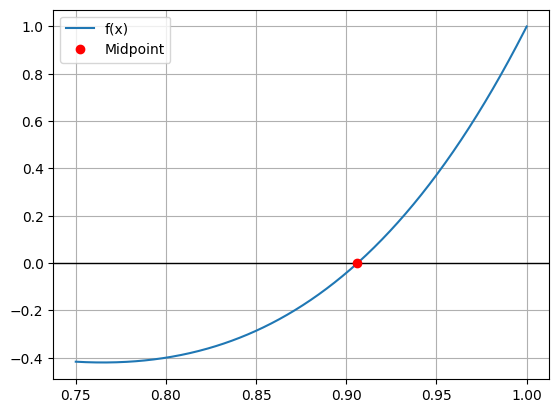

In [10]:
import matplotlib.animation as animation
from IPython.display import HTML

# Plot setup
fig, ax = plt.subplots()
x_vals = np.linspace(a, b, 400)
ax.plot(x_vals, f(x_vals), label="f(x)")
ax.axhline(0, color="black", linewidth=1)
point, = ax.plot([], [], "ro", label="Midpoint")
plt.grid()
plt.legend()

def init():
    point.set_data([], [])
    return (point,)

def update(i):
    x = mids[i]
    point.set_data([x], [f(x)])
    return (point,)

# Create animation
ani = animation.FuncAnimation(
    fig, update, frames=len(mids),
    init_func=init, blit=True, interval=800, repeat=False
)


# Display in Jupyter / Colab
HTML(ani.to_jshtml())

Bisection found root 0.9061798459733836 in 31 iterations.
Residual on approximate solution is 2.38535626354048e-10


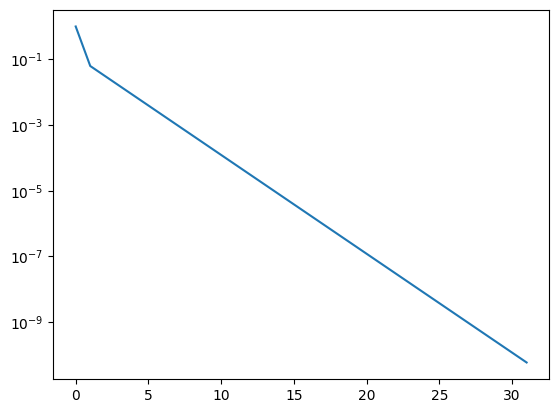

In [11]:
print("Bisection found root", alpha, "in", iters_bisect, "iterations.")
print("Residual on approximate solution is", abs(f(alpha)))

plt.semilogy(errors_bisect)

### Theoretical number of iterations to reach target accuracy
At each iteration $k$ of the bisection method we have the zero $\alpha\in (a^{(k)},b^{(k)})$; we can therefore explicitly estimate the error at each step:
$$ e^{(k)} := \vert x^{(k)} - \alpha \vert \leq \frac{b^{(k)} - a^{(k)}}{2} = \frac{b-a}{2^{k+1}}.$$

If an accuracy $\epsilon$ is desired, we can impose the bound
$$ \frac{b-a}{2^{k+1}} \leq \epsilon$$
so that we can know _a priori_ the number of iterations $k_\epsilon$ needed to obtain the desired accuracy:
$$ k_\epsilon \geq  \log_2\left(\frac{b-a}{\epsilon}\right) - 1.$$

In [12]:
it_theor = (np.log(np.abs(b-a)) - np.log(eps))/np.log(2)
print(it_theor)

31.219280948873624


## Newton's method

In order to find out other methods for solving non-linear equations, let's compute the Taylor's series of $f(x)$ up to the first order near $x^{(k)}$:
$$
f(x) \simeq f(x^{(k)}) + (x-x^{(k)})f^{\prime}(x^{(k)})
$$
which suggests the following iterative scheme
$$
x^{(k+1)} = x^{(k)} - \frac{f(x^{(k)})}{f^{\prime}(x^{(k)})}
$$
known as the Newton method.

In [13]:
def newton(f, f_prime, x0, eps, n_max):
    """
    Newton's method for finding a root of a real-valued function.

    Parameters
    ----------
    f : Callable[[float], float]
        Function whose root we want to approximate.
    f_prime : Callable[[float], float]
        Derivative of f.
    x0 : float
        Initial guess for the root.
    eps : float, optional (default=1e-8)
        Stopping tolerance. The iteration stops when the error is <= eps.
    n_max : int, optional (default=100)
        Maximum number of iterations.

    Returns
    -------
    root : float
        Approximate root of f.
    n_iter : int
        Number of iterations performed.
    errors : List[float]
        History of error estimates at each iteration.

    Notes
    -----
    - Newton’s method has **quadratic convergence** if the initial guess is close 
      enough to the root and f'(x) ≠ 0.
    - If f'(x) ≈ 0 at any step, the method may fail or diverge.
    """

    # Check derivative at initial guess
    if np.abs(f_prime(x0)) < 1e-16:
        raise ValueError("Derivative at initial guess is too small.")

    # Initialization
    err = float("inf")
    errors = [err]
    it = 0
    x = x0

    # Iteration
    while err > eps and it < n_max:
        qk = f_prime(x)

        if abs(qk) < 1e-12:
            raise RuntimeError("Derivative too close to zero during iteration.")

        # Newton update
        x_new = x - f(x) / qk

        # Error estimate (difference in successive iterates)
        err = abs(x_new - x)
        errors.append(err)

        # Update for next iteration
        x = x_new
        it += 1

    return x, it, errors

In [14]:
%time
[alpha, iters_newton, errors_newton] = newton(f, f_prime, 1.0, eps, n_max)

CPU times: total: 0 ns
Wall time: 3.81 μs


Newton found root 0.906179845938664 in 6 iterations.
Residual on approximate solution is 0.0


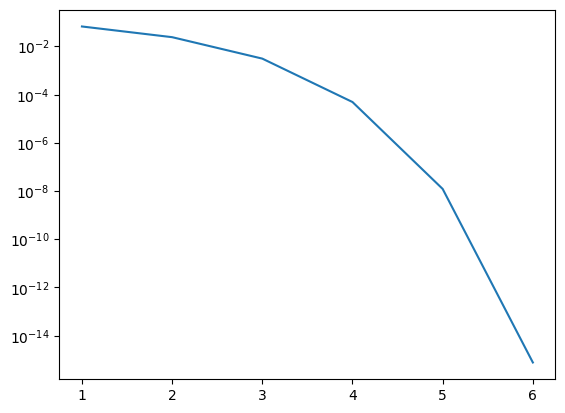

In [15]:
print("Newton found root", alpha, "in", iters_newton, "iterations.")
print("Residual on approximate solution is", np.abs(f(alpha)))
plt.semilogy(errors_newton)

## Chord method

$$
q^{(k)} \equiv q = \frac{f(b)-f(a)}{b-a}
$$

$$
x^{(k+1)} = x^{(k)} - \frac{f(x^{(k)})}{q}
$$

In [16]:
def chord(f, a, b, x0, eps, n_max):
    """
    Implementation of the chord (secant) method to find a root of f(x).
    
    Parameters:
        f      : Function whose root is sought.
        a, b   : Interval endpoints used to calculate initial slope.
        x0     : Initial guess.
        eps    : Desired accuracy (default 1e-6).
        n_max  : Maximum number of iterations (default 100).
    
    Returns:
        x      : Approximated root.
        it     : Number of iterations performed.
        errors : List of errors at each iteration.
    """
    q = (f(b) - f(a)) / (b - a)
    errors = [eps + 1.]  # Initialize with a large error
    x = x0
    it = 0

    while errors[-1] > eps and it < n_max:
        x_new = x - f(x) / q
        err = abs(x_new - x)
        errors.append(err)
        x = x_new
        it += 1

    return x, it, errors

Chords found root 0.9061798459469729 in 13 iterations.
Residual on approximate solution is 5.70847473767655e-11


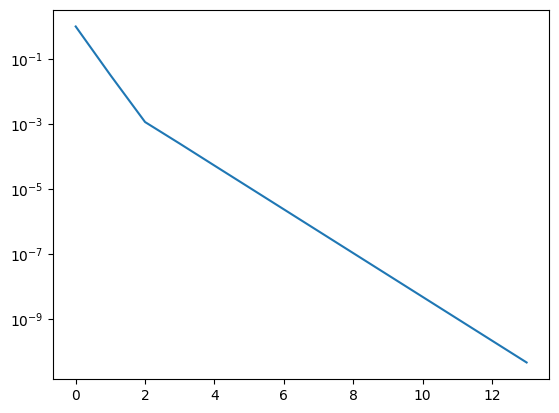

In [17]:
[alpha, iters_chord, errors_chords] = chord(f, a, b, x0, eps, n_max)
print("Chords found root", alpha,"in", iters_chord, "iterations.")
print("Residual on approximate solution is", abs(f(alpha)))
plt.semilogy(errors_chords)

## Secant method

$$
q^{(k)} = \frac{f(x^{(k)})-f(x^{(k-1)})}{x^{(k)} - x^{(k-1)}}
$$

$$
x^{(k+1)} = x^{(k)} - \frac{f(x^{(k)})}{q^{(k)}}
$$

Note that this algorithm requires **two** initial points

In [18]:
def secant(f, x0, x00, eps, n_max):
    """
    Implementation of the secant method to find a root of a function f(x).

    Parameters:
        f      : callable
                 The function whose root is to be found.
        x0     : float
                 The first initial guess for the root.
        x00    : float
                 The second initial guess for the root.
        eps    : float
                 Desired accuracy; the iteration stops when the absolute change 
                 between consecutive approximations is less than eps.
        n_max  : int
                 Maximum number of iterations allowed.

    Returns:
        xk     : float
                 The approximated root of the function.
        it     : int
                 The number of iterations performed.
        errors : list of float
                 List of absolute errors at each iteration 
                 (|x_new - x_old|).
    """
    err = eps + 1.
    errors = [err]
    it = 0
    xk = x0
    xkk = x00

    while (err > eps and it < n_max):
          qk = (f(xk) - f(xkk))/(xk - xkk)
          x_new = xk - f(xk)/qk
          err = abs(x_new - xk)
          xkk = xk
          xk = x_new
          errors.append(err)
          it += 1
    return xk, it, errors


Secant found root 0.906179845938664 in 7 iterations.
Residual on approximate solution is 0.0


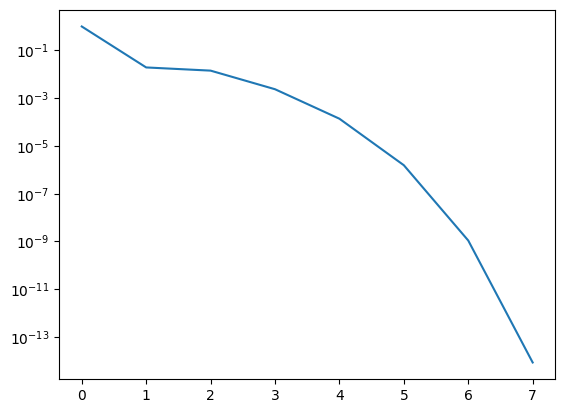

In [19]:
[alpha, iters_secant, errors_secant] = secant(f, x0, x00, eps, n_max)
print("Secant found root", alpha, "in", iters_secant, "iterations.")
print("Residual on approximate solution is", abs(f(alpha)))
plt.semilogy(errors_secant)

## Fixed point iterations

The idea is to transform the problem $f(x) = 0$ into $x-\phi(x)=0$, where $\phi(\alpha)= \alpha \iff f(\alpha)=0$, so that we can use the _fixed point iteration_ 
$$ x^{(k+1)} = \phi(x^{(k)}).$$


We want to solve $f(t) = \dfrac{t}{8}\left(63 t^4 - 70 t^2 + 15\right) = 0$; we can focus our attention on the roots finding of $f_1 = 63 t^4 - 70 t^2 + 15$.

We recast $f_1(t)$ in terms of $t - \phi(t)$ in many ways:

- Dividing by $70t$: 
$$\dfrac{63}{70}t^3 - t + \dfrac{15}{70t} = 0 \implies \phi_1 = \dfrac{63}{70}t^3 + \dfrac{15}{70t}$$

- Dividing by $63t^3$:
$$t - \dfrac{70}{63t} + \dfrac{15}{63t^3} = 0 \implies \phi_2 = \dfrac{70}{63t} - \dfrac{15}{63t^3}$$

- Multiplying by $\dfrac{t}{15}$:
$$\dfrac{63}{15}t^5 - \dfrac{70}{15}t^3 + t  = 0 \implies \phi_3 = -\dfrac{63}{15}t^5 + \dfrac{70}{15}t^3$$

- Finally:
$$70t^2 = 63t^4 + 15 \implies t = \sqrt{\dfrac{63t^4 + 15}{70}} \implies \phi_4 = \sqrt{\dfrac{63t^4 + 15}{70}}$$

In [20]:
phi1 = lambda x : 63./70.*x**3 + 15./(70.*x)
phi1_prime = lambda x : 63./70.*3*x**2 - 15./(70.*x**2)

phi2 = lambda x : 70.0/(63.*x) - 15/(63*x**3)
phi2_prime = lambda x : -70./(63*x**2) + 15.*3./(63.*x**4)

phi3 = lambda x : 70.0/15.0*x**3 - 63.0/15.0*x**5
phi3_prime = lambda x : 70./15.0*3*x**2 - 63.0/15.0*5*x**4

phi4 = lambda x : np.sqrt((63.*x**4 + 15.0)/70.)
phi4_prime = lambda x : 1.0/(2.0*np.sqrt((63.*x**4 + 15.0)/70.))*(63.*4*x**3/70.)

phi_funcs = [phi1, phi2, phi3, phi4]
phi_primes = [phi1_prime, phi2_prime, phi3_prime, phi4_prime]
labels = [r"$\phi_1$", r"$\phi_2$", r"$\phi_3$", r"$\phi_4$"]

In [21]:
def fixed_point(phi, x0, eps, n_max):
    """
    Implementation of the fixed-point iteration method to find a solution of x = phi(x).

    Parameters:
        phi    : callable
                 Function representing the iteration, x = phi(x).
        x0     : float
                 Initial guess for the fixed point.
        eps    : float
                 Desired accuracy; iteration stops when the absolute difference
                 between consecutive approximations is less than eps.
        n_max  : int
                 Maximum number of iterations allowed.

    Returns:
        x      : float
                 Approximated fixed point.
        it     : int
                 Number of iterations performed.
        errors : list of float
                 List of absolute differences between consecutive approximations.
    """
    x = x0
    err = eps + 1.
    errors = [err]
    it = 0
    while (err > eps and it < n_max):
        x_new = phi(x)
        err = abs(x_new - x)
        x = x_new
        it +=1
        errors.append(err)

    return x, it, errors

Remember that for the fixed point method the convergence to $\alpha$ is guaranteed only if $|\phi'(\alpha)|<1$.

Fixed point found root 0.5384693101075695 in 11 iterations.
Residual on approximate solution is 4.576200390861621e-12
phi_prime(alpha)= 0.04381711254314846
Fixed point found root 0.9061798459220886 in 18 iterations.
Residual on approximate solution is 1.1387894412294684e-10
phi_prime(alpha)= -0.2938074859988866
Fixed point found root 4.444733555182444e-87 in 8 iterations.
Residual on approximate solution is 8.333875415967082e-87
phi_prime(alpha)= 2.765791892719068e-172
Fixed point found root 0.5384693101841499 in 37 iterations.
Residual on approximate solution is 1.9035195383044888e-10
phi_prime(alpha)= 0.5219085564547101


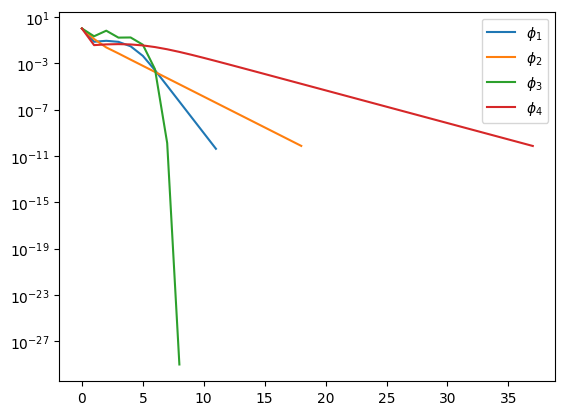

In [22]:
# Let's see the convergence for the different phi functions
i = 0
for phi, phi_prime in zip(phi_funcs, phi_primes):
    [alpha, iters_fixed, errors_fixed] = fixed_point(phi, 0.8, eps, n_max)
    print("Fixed point found root", alpha, "in", iters_fixed, "iterations.")
    print("Residual on approximate solution is", abs(f(alpha)))
    
    plt.semilogy(errors_fixed, label=labels[i])

    print("phi_prime(alpha)=", phi_prime(alpha))
    i += 1
plt.legend()

## Comparison

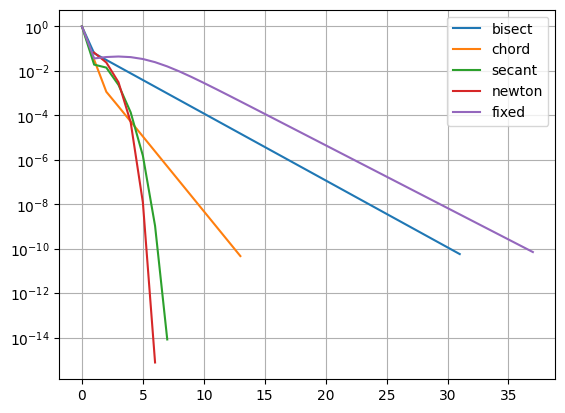

In [23]:
# plot the error convergence for the methods
plt.semilogy(errors_bisect, label='bisect')
plt.semilogy(errors_chords, label='chord')
plt.semilogy(errors_secant, label='secant')
plt.semilogy(errors_newton, label ='newton')
plt.semilogy(errors_fixed, label ='fixed')
plt.grid()
plt.legend()

## On the convergence of the Newton method
We know, and have numerically confirmed, that the convergence rate of the Newton method is quadratic, at least in some **_good_** situations. 
In particular the convergence of Newton method becomes linear when we are seeking zeroes with multiplicity higher than 1.

As a simple example let us consider the following polynomial: 
$$ f(x) = x^2(x^3-1).$$
As a real function of real variable, this polynomial has one simple root at $1$ and a double root at $0$. 

In [24]:
t = sym.symbols('t')
f_sym = t**2*(t**3-1) 
f_prime_sym = sym.diff(f_sym,t)
f = sym.lambdify(t, f_sym, 'numpy')
f_prime = sym.lambdify(t,f_prime_sym, 'numpy')

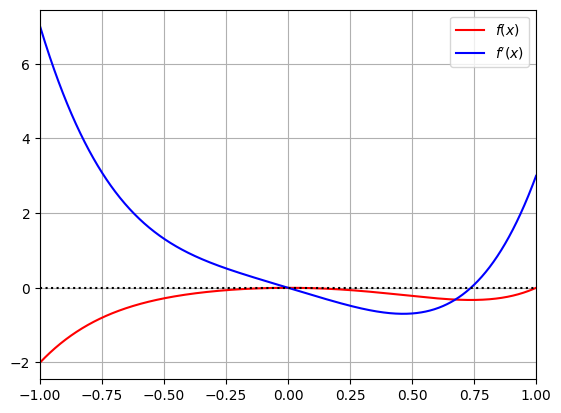

In [25]:
plt.plot(x, f(x), label="$f(x)$", color="r")
plt.plot(x, f_prime(x), label="$f'(x)$", color="b")
plt.axhline(0, color="black", linestyle="dotted")
plt.grid()
plt.xlim(-1, 1)
plt.legend()

The Newton method will converge in a lot of iterations!

Newton found root -6.553090510722184e-11 in 76 iterations.
Residual on approximate solution is 4.294299524171714e-21


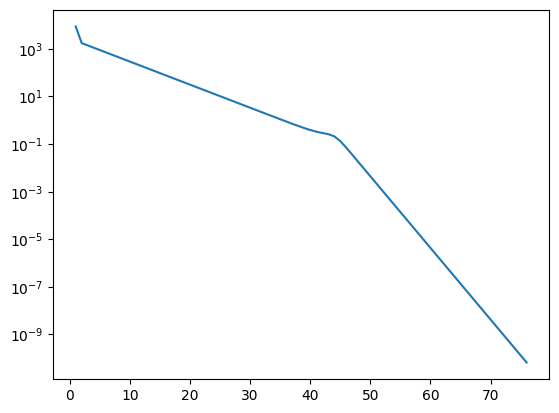

In [26]:
[alpha, iters_newton, errors_newton] = newton(f, f_prime, 0.7368, eps, n_max)
print("Newton found root", alpha, "in", iters_newton, "iterations.")
print("Residual on approximate solution is", abs(f(alpha)))
plt.semilogy(errors_newton)

Let's try with the modified Newton, where:
$$
x^{(k+1)} = x^{(k)} - m\frac{f(x^{(k)})}{f^{\prime}(x^{(k)})}
$$, where $m$ is the multiplicity of the zero we are seeking.
This modification take back the method to quadratic convergence.

In [27]:
def newton_multi(f, f_prime, x0, m, eps, n_max):
    """
    Newton-Raphson method for finding a root of a function with known multiplicity.

    This is a modified version of the Newton-Raphson method designed for
    roots of multiplicity m, where the standard Newton method converges slowly.

    Parameters:
        f       : callable
                  Function whose root is to be found.
        f_prime : callable
                  Derivative of the function f.
        x0      : float
                  Initial guess for the root.
        m       : int or float
                  Multiplicity of the root.
        eps     : float
                  Desired accuracy; iteration stops when the absolute difference
                  between consecutive approximations is less than eps.
        n_max   : int
                  Maximum number of iterations allowed.

    Returns:
        x       : float
                  Approximated root of the function.
        it      : int
                  Number of iterations performed.
        errors  : list of float
                  List of absolute differences between consecutive approximations.
    """
    err = eps + 1
    errors = [err]

    x = x0

    it = 0 
    while(err > eps and it < n_max):
    	q = f_prime(x)
    	if(abs(q)<1e-13):
    		break

    	x_new = x - m * f(x)/q

    	err = abs(x_new - x)
    	errors.append(err)

    	x = x_new 
    	it += 1

    return x, it, errors

Newton-Raphson found root 0.0 in 4 iterations.
Residual on approximate solution is 0.0


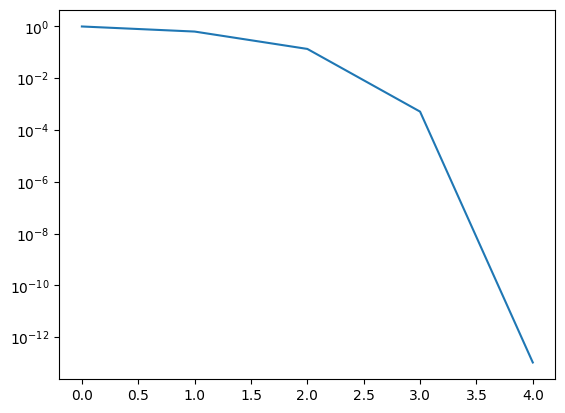

In [28]:
[alpha, iters_multinewton, errors_multinewton] = newton_multi(f, f_prime, 0.5, 2, eps, n_max)
print("Newton-Raphson found root", alpha, "in", iters_multinewton, "iterations.")
print("Residual on approximate solution is", abs(f(alpha)))
plt.semilogy(errors_multinewton)

Here there is a comparison between the methods we have tested.
| Method                               | Convergence Type           | Required Inputs                             | Notes / Comments                                                       |       |                                         |
| ------------------------------------ | -------------------------- | ------------------------------------------- | ---------------------------------------------------------------------- | ----- | --------------------------------------- |
| **Bisection (`bisect`)**             | Linear                     | `f`, interval `[a,b]`, `eps`, `n_max`       | Guaranteed convergence if `f(a)*f(b)<0`. Slow but reliable.            |       |                                         |
| **Newton (`newton`)**                | Quadratic (simple root)    | `f`, `f_prime`, `x0`, `eps`, `n_max`        | Fast convergence near a simple root. Fails if `f'(x)` is near zero.    |       |                                         |
| **Chord (`chord`)**                  | Linear                     | `f`, interval `[a,b]`, `x0`, `eps`, `n_max` | Fixed slope approximation of Newton. Slower but derivative not needed. |       |                                         |
| **Secant (`secant`)**                | Superlinear (~1.618)       | `f`, `x0`, `x00`, `eps`, `n_max`            | No derivative required. Uses two previous points.                      |       |                                         |
| **Fixed Point (`fixed_point`)**      | Linear (depends on `φ'`)     | `phi`, `x0`, `eps`, `n_max`                 | Converges if                                                            `abs(φ'(α))< 1`. Useful for transforming equations. |
| **Modified Newton (`newton_multi`)** | Quadratic (multiple roots) | `f`, `f_prime`, `x0`, `m`, `eps`, `n_max`   | Accelerates convergence for roots with known multiplicity `m`.         |       |                                         |


## Exercise
Consider the function $g(x) = x^3 - 6x^2 + 11x - 6$.

**1**) Plot the function $g(x)$ in the interval `[0, 4]` and identify approximate locations of all roots.

**2**) Apply all root-finding methods (bisection, Newton, chord, secant, fixed point)

**3**) Compare performance:
    - Record the number of iterations required by each method.
    - Compute the residuals $|g(\alpha)|$ for the approximate roots.
    - Comment on which methods converge fastest or lowest.

**4**) Modify the function to include multiple roots: $h(x) = (x-1)^2 (x-2)(x-3)$.
    - Apply the Newton method, and modified Newton method to the multiple root.
    - Compare convergence rates and iteration counts.

**5**) Error convergence:
    - Plot the error history for each method on a semilogarithmic scale.
    - Discuss how the convergence differs for simple and multiple roots.

**6**) BONUS: try to animate how the solution evolves among iterations, for different fixed point functions $\phi$ (in the same plot)

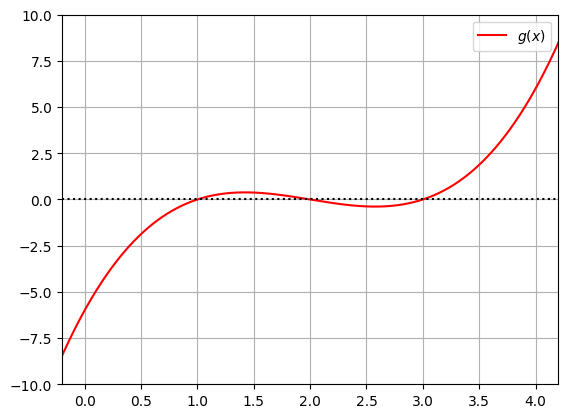

In [29]:
g = lambda x: x**3 - 6*x**2 + 11*x - 6
xx = np.linspace(-1.5, 5.5, 1000)

plt.plot(xx, g(xx), label="$g(x)$", color="r")

plt.axhline(0, color="black", linestyle="dotted")
plt.grid()
plt.xlim(-0.2, 4.2)
plt.ylim(-10, 10)
plt.legend()


